## DistilRoBERTa

In [1]:
# import packages
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
    

In [2]:
# Load data 
train_df = pd.read_csv("../2_preprocessing/train_case_sensitive.csv")
val_df = pd.read_csv("../2_preprocessing/validation_case_sensitive.csv")
test_df = pd.read_csv("../2_preprocessing/test_case_sensitive.csv")

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)
data = DatasetDict({"train": train_dataset, "validation": val_dataset, "test": test_dataset})

In [5]:
# Load DistilRoBERTa tokenizer
#tokenizer = RobertaTokenizer.from_pretrained("distilroberta-base")

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples["script"], padding="max_length", truncation=True)

tokenized_datasets = data.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["script"])  # Remove raw text after tokenization
tokenized_datasets = tokenized_datasets.rename_column("passed_bechdel", "labels")  # Rename for Trainer compatibility
tokenized_datasets.set_format("torch")  # Use PyTorch tensors


Map:   0%|          | 0/1418 [00:00<?, ? examples/s]

Map:   0%|          | 0/177 [00:00<?, ? examples/s]

Map:   0%|          | 0/178 [00:00<?, ? examples/s]

In [4]:
#tokenizer.save_pretrained("./fine_tuned_distilroberta")

# reload
#tokenizer = RobertaTokenizer.from_pretrained("distilroberta-base")
tokenizer = RobertaTokenizer.from_pretrained("./fine_tuned_distilroberta")


In [6]:
# fine-tuning model
# Load RobertaForSequenceClassification with DistilRoBERTa's pre-trained weights
model_name = 'distilroberta'
model = RobertaForSequenceClassification.from_pretrained("distilroberta-base", num_labels=2)  

results_df = pd.DataFrame(columns=[
    "model", "split", "accuracy", "f1_score", "roc_auc", 
    "true_negatives", "true_positives", "false_positives", "false_negatives", "precision", "recall", 
    "true_negative_rate", "false_negative_rate", "false_positive_rate"])

# Define evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)

    # Confusion Matrix
    cm = confusion_matrix(labels, predictions)
    tn, fp, fn, tp = cm.ravel()

    # ROC-AUC Score 
    roc_auc = roc_auc_score(labels, logits[:, 1])

    # Plot and save confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Failed", "Passed"])
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set_title(f"{model_name}, data split: {datasplit}")
    plt.savefig(f'./output/figures/{model_name}_{datasplit}_confusion_matrix.jpeg')
    #plt.savefig(f"./output/figures/distilroberta_confusion_matrix_epoch_{trainer.state.epoch}.png")
    plt.show()

    # Append results to DataFrame
    results_df.loc[len(results_df)] = {
        "model": model_name, 
        "split": datasplit,  
        "accuracy": acc,
        "f1_score": f1, 
        "roc_auc": roc_auc,
        "true_negatives": tn, 
        "true_positives": tp,
        "false_positives": fp,
        "false_negatives": fn, 
        "precision": precision, 
        "recall": recall, 
        "true_negative_rate": tn/(tn+fp), 
        "false_negative_rate": fn/(fn+tp), 
        "false_positive_rate": fp/(fp+tn)
    }

    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",       # Evaluate at the end of each epoch
    save_strategy="epoch",             # Save checkpoint at each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=64, # changed from 16 to 64
    per_device_eval_batch_size=64, # changed from 16 to 64
    num_train_epochs=3,
    weight_decay=0.01,
   # warmup_steps = 500,
    #logging_dir="./logs",
    load_best_model_at_end=True,       # Load the best model based on chosen metric
    metric_for_best_model="f1",  # Select best model based on f1
    save_total_limit=2,                 # Save at most 2 checkpoints
    seed = 42,
    logging_steps=10  # Log every 10 steps # ADDED
)

# Set up the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset = tokenized_datasets['validation'],  # Validation dataset for evaluation
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.688500,0.680234,0.604520,0.566303,0.658172,0.604520
2,0.678000,0.630404,0.694915,0.688953,0.709933,0.694915
3,0.645700,0.589452,0.728814,0.728189,0.730561,0.728814


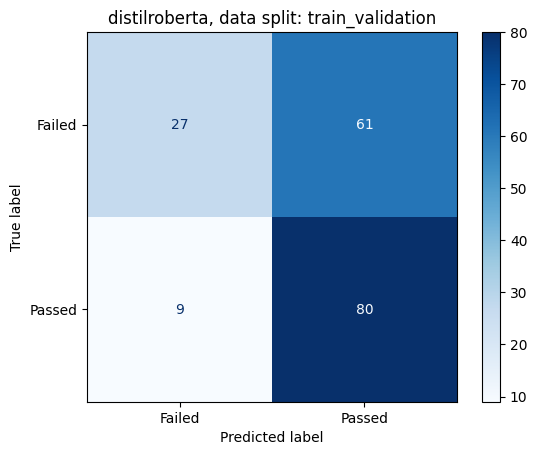

/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


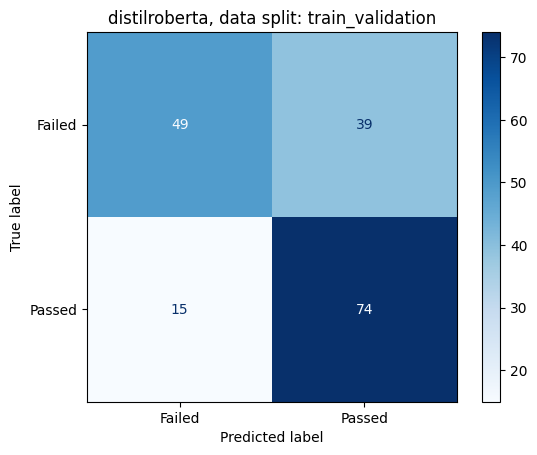

/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


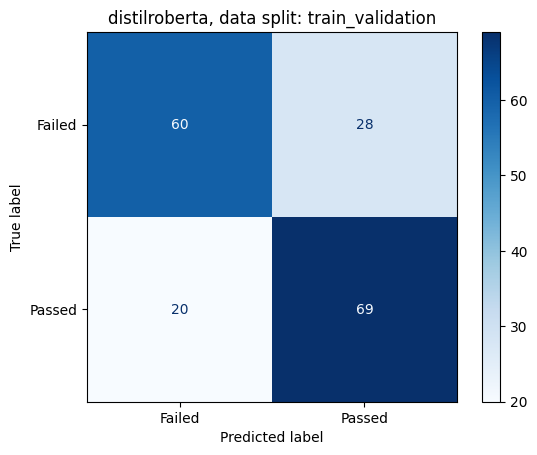

,model,split,accuracy,f1_score,roc_auc,true_negatives,true_positives,false_positives,false_negatives,precision,recall,true_negative_rate,false_negative_rate,false_positive_rate
0,distilroberta,train_validation,0.604520,0.566303,0.777962,27,80,61,9,0.658172,0.604520,0.306818,0.101124,0.693182
1,distilroberta,train_validation,0.694915,0.688953,0.784346,49,74,39,15,0.709933,0.694915,0.556818,0.168539,0.443182
2,distilroberta,train_validation,0.728814,0.728189,0.790347,60,69,28,20,0.730561,0.728814,0.681818,0.224719,0.318182


In [ ]:
# Train the model 
datasplit = 'train_validation'
trainer.train()
results_df

In [ ]:
# save model
#model.save_pretrained("./fine_tuned_distilroberta")

# reload model
#model = RobertaForSequenceClassification.from_pretrained("./fine_tuned_distilroberta")

/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


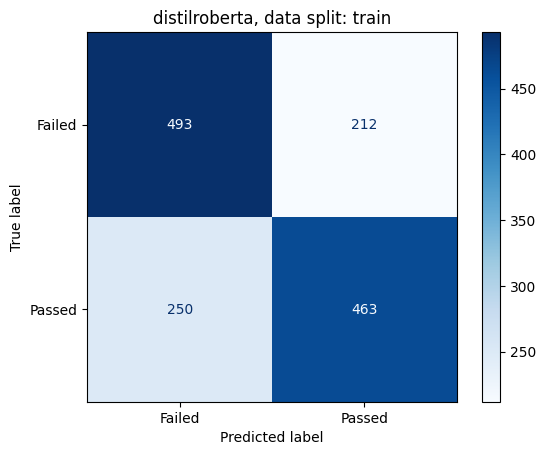

Training Metrics: {'eval_loss': 0.6109392642974854, 'eval_accuracy': 0.6741889985895627, 'eval_f1': 0.6740041940785171, 'eval_precision': 0.6747892721276271, 'eval_recall': 0.6741889985895627, 'eval_runtime': 5.6091, 'eval_samples_per_second': 252.804, 'eval_steps_per_second': 2.139, 'epoch': 3.0}


,model,split,accuracy,f1_score,roc_auc,true_negatives,true_positives,false_positives,false_negatives,precision,recall,true_negative_rate,false_negative_rate,false_positive_rate
0,distilroberta,train_validation,0.604520,0.566303,0.777962,27,80,61,9,0.658172,0.604520,0.306818,0.101124,0.693182
1,distilroberta,train_validation,0.694915,0.688953,0.784346,49,74,39,15,0.709933,0.694915,0.556818,0.168539,0.443182
2,distilroberta,train_validation,0.728814,0.728189,0.790347,60,69,28,20,0.730561,0.728814,0.681818,0.224719,0.318182
3,distilroberta,train,0.674189,0.674004,0.739952,493,463,212,250,0.674789,0.674189,0.699291,0.350631,0.300709


In [ ]:
# get specific values for train
datasplit = 'train'
train_metrics = trainer.evaluate(eval_dataset=tokenized_datasets["train"])
print("Training Metrics:", train_metrics)
results_df

/home/ucloud/.local/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


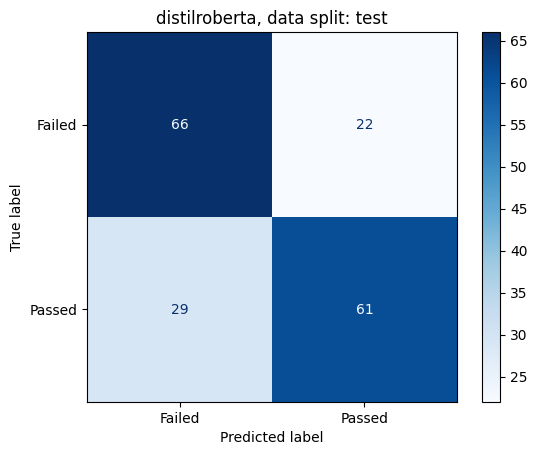


Test Results After Training:


,model,split,accuracy,f1_score,roc_auc,true_negatives,true_positives,false_positives,false_negatives,precision,recall,true_negative_rate,false_negative_rate,false_positive_rate
0,distilroberta,train_validation,0.604520,0.566303,0.777962,27,80,61,9,0.658172,0.604520,0.306818,0.101124,0.693182
1,distilroberta,train_validation,0.694915,0.688953,0.784346,49,74,39,15,0.709933,0.694915,0.556818,0.168539,0.443182
2,distilroberta,train_validation,0.728814,0.728189,0.790347,60,69,28,20,0.730561,0.728814,0.681818,0.224719,0.318182
3,distilroberta,train,0.674189,0.674004,0.739952,493,463,212,250,0.674789,0.674189,0.699291,0.350631,0.300709
4,distilroberta,test,0.713483,0.713166,0.718561,66,61,22,29,0.715064,0.713483,0.750000,0.322222,0.250000


In [9]:
# Explicitly evaluate the model on the test dataset after training
datasplit = "test"
test_results = trainer.evaluate(eval_dataset=tokenized_datasets["test"])
print("\nTest Results After Training:")
test_results
results_df

# Save results

In [24]:
# adding to the performance df for plotting 
# reload other performances
performance_df = pd.read_csv('/work/classes/NLP_exam/3_model_selection/output/performance_df.csv')

In [27]:
# concatenate old and new performances
performance_df_distil_full = pd.concat([performance_df, results_df], ignore_index=True)
performance_df_distil_full

,model,split,accuracy,f1_score,roc_auc,true_negatives,true_positives,false_positives,false_negatives,precision,recall,true_negative_rate,false_negative_rate,false_positive_rate
0,BoW_log_reg,train,0.784200,0.777000,0.859543,579,533,126,180,0.808801,0.747546,0.821277,0.252454,0.178723
1,BoW_log_reg,validation,0.785300,0.771100,0.865424,75,64,13,25,0.831169,0.719101,0.852273,0.280899,0.147727
2,BoW_log_reg,test,0.713500,0.687100,0.744949,71,56,17,34,0.767123,0.622222,0.806818,0.377778,0.193182
3,BoW_rf,train,0.803200,0.791900,0.887491,608,531,97,182,0.845541,0.744741,0.862411,0.255259,0.137589
4,BoW_rf,validation,0.745800,0.723900,0.841420,73,59,15,30,0.797297,0.662921,0.829545,0.337079,0.170455
5,BoW_rf,test,0.674200,0.637500,0.736111,69,51,19,39,0.728571,0.566667,0.784091,0.433333,0.215909
6,BoW_svc,train,0.913300,0.910300,0.975125,671,624,34,89,0.948328,0.875175,0.951773,0.124825,0.048227
7,BoW_svc,validation,0.762700,0.737500,0.846272,76,59,12,30,0.830986,0.662921,0.863636,0.337079,0.136364
8,BoW_svc,test,0.685400,0.650000,0.756881,70,52,18,38,0.742857,0.577778,0.795455,0.422222,0.204545
9,tf_idf_log_reg,train,0.784900,0.771900,0.856647,597,516,108,197,0.826923,0.723703,0.846809,0.276297,0.153191


In [37]:
# save 
#performance_df_distil_full.to_csv('/work/classes/NLP_exam/3_model_selection/output/performance_df_w_distil_full.csv', index = False)

# reload
performance_df_distil_full = pd.read_csv('/work/classes/NLP_exam/3_model_selection/output/performance_df_w_distil_full.csv')

In [ ]:
# now delete the two training epochs (index 18 and 19)
performance_df_distil_full = performance_df_distil_full.drop([18,19]) 
performance_df_distil_full = performance_df_distil_full.reset_index(drop = True)# reset reset_index 
# change name of train_validation to validation
performance_df_distil_full.loc[performance_df_distil_full['split'] == 'train_validation', 'split'] = 'validation' 

performance_df_distil_full

,model,split,accuracy,f1_score,roc_auc,true_negatives,true_positives,false_positives,false_negatives,precision,recall,true_negative_rate,false_negative_rate,false_positive_rate
0,BoW_log_reg,train,0.784200,0.777000,0.859543,579,533,126,180,0.808801,0.747546,0.821277,0.252454,0.178723
1,BoW_log_reg,validation,0.785300,0.771100,0.865424,75,64,13,25,0.831169,0.719101,0.852273,0.280899,0.147727
2,BoW_log_reg,test,0.713500,0.687100,0.744949,71,56,17,34,0.767123,0.622222,0.806818,0.377778,0.193182
3,BoW_rf,train,0.803200,0.791900,0.887491,608,531,97,182,0.845541,0.744741,0.862411,0.255259,0.137589
4,BoW_rf,validation,0.745800,0.723900,0.841420,73,59,15,30,0.797297,0.662921,0.829545,0.337079,0.170455
5,BoW_rf,test,0.674200,0.637500,0.736111,69,51,19,39,0.728571,0.566667,0.784091,0.433333,0.215909
6,BoW_svc,train,0.913300,0.910300,0.975125,671,624,34,89,0.948328,0.875175,0.951773,0.124825,0.048227
7,BoW_svc,validation,0.762700,0.737500,0.846272,76,59,12,30,0.830986,0.662921,0.863636,0.337079,0.136364
8,BoW_svc,test,0.685400,0.650000,0.756881,70,52,18,38,0.742857,0.577778,0.795455,0.422222,0.204545
9,tf_idf_log_reg,train,0.784900,0.771900,0.856647,597,516,108,197,0.826923,0.723703,0.846809,0.276297,0.153191


In [ ]:
# save
performance_df_distil_full.to_csv('/work/classes/NLP_exam/3_model_selection/output/performance_df_w_distil_v2.csv', index = False)

# Plot model performances

In [42]:
# reload for plotting
performance_df_distil = pd.read_csv('/work/classes/NLP_exam/3_model_selection/output/performance_df_w_distil_v2.csv')

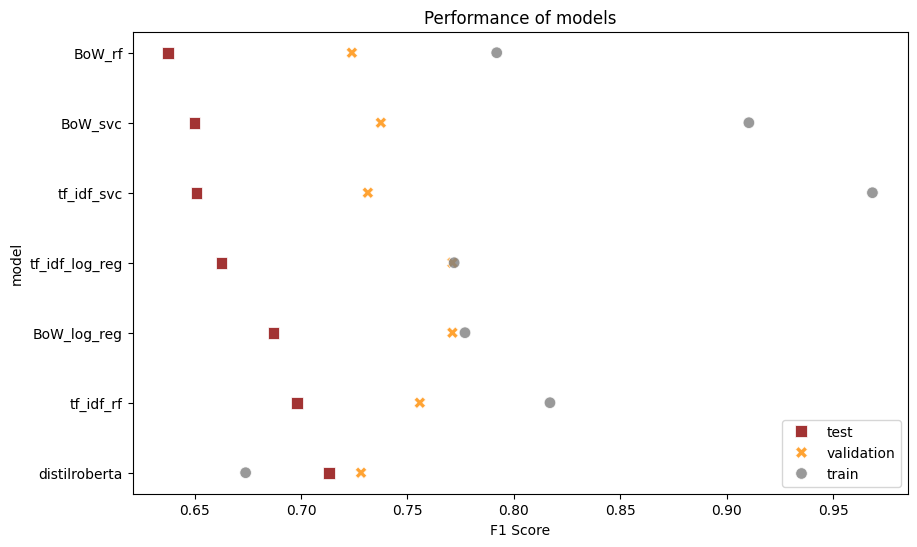

In [ ]:
# make performance plot
# Specify the order of the legend and the icons
order = ['test', 'validation', 'train']
markers = {'test': 's', 'validation': 'X', 'train': 'o'}

# Sort the DataFrame by split and f1_score
performance_df_distil['split_order'] = performance_df_distil['split'].map({v: i for i, v in enumerate(order)})  # Map splits to numeric order
performance_df_sorted = performance_df_distil.sort_values(by=['split_order', 'f1_score'], ascending=[True, True])  # Sort by split order and f1_score

# Plot
fig, ax = plt.subplots(figsize=(10, 6))  # Make wider to show all points
sns.scatterplot(data=performance_df_sorted, 
                y='model', 
                x='f1_score', 
                style='split',
                hue='split', 
                markers=markers,
                palette=['darkred', 'darkorange', 'grey'],
                hue_order=order, 
                style_order=order, 
                s=70,
                alpha=0.8)

# Customize plot
plt.title("Performance of models")
plt.xlabel("F1 Score")
plt.legend(loc='lower right')  # Adjust legend position

# Remove temporary column used for sorting
performance_df_distil.drop(columns='split_order', inplace=True)
#plt.savefig('../figures/model_performance_w_distil.jpeg', format='jpeg', dpi=300) 
plt.show()

# Feature importances

need to start new virtul env, see BoW_tf_idf script for a detailed explanation

In [3]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, classification_report, roc_auc_score, roc_curve, average_precision_score, make_scorer, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

import pickle as pkl
import shap
print('np version:', np.__version__)

import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict

np version: 2.0.0


In [32]:
tokenizer = RobertaTokenizer.from_pretrained("./fine_tuned_distilroberta")

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples["script"], padding="max_length", truncation=True)

tokenized_datasets = data.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["script"])  # Remove raw text after tokenization
tokenized_datasets = tokenized_datasets.rename_column("passed_bechdel", "labels")  # Rename for Trainer compatibility
tokenized_datasets.set_format("torch")  # Use PyTorch tensors

Map:   0%|          | 0/1418 [00:00<?, ? examples/s]

Map:   0%|          | 0/177 [00:00<?, ? examples/s]

Map:   0%|          | 0/178 [00:00<?, ? examples/s]

In [44]:
tokenized_datasets['validation'][0:5]['input_ids']

tensor([[    0, 13354, 26207,  ...,  4259,    20,     2],
        [    0,  3764,  9298,  ...,    37,  3369,     2],
        [    0,   347,  2336,  ...,    62,    85,     2],
        [    0,  7981,  1941,  ...,     5,  2311,     2],
        [    0, 35163, 32175,  ...,    69,   978,     2]])

In [ ]:
# Load model
#model = RobertaForSequenceClassification.from_pretrained("distilroberta-base", num_labels=2)

# Function to predict probabilities for SHAP
def predict_probabilities(tokenized_inputs):
    # Ensure the input tensors are on the same device as the model
    inputs = {key: val.to(model.device) for key, val in tokenized_inputs.items()}
    
    # Get model outputs
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Compute probabilities using softmax
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()
    return probabilities

# Initialize SHAP explainer
# The masker uses the tokenizer since the text is already tokenized
explainer = shap.Explainer(
    model=predict_probabilities,  # The wrapper function for your model
    masker=shap.maskers.Text(tokenizer),  # Use the Hugging Face tokenizer for masking
)

# Sample tokenized inputs from the validation dataset
sample_tokenized_inputs = tokenized_datasets['validation'][0:5]['input_ids']  # Select 5 samples for SHAP

# Compute SHAP values for the sample tokenized inputs
shap_values = explainer(sample_tokenized_inputs)

# Visualize the SHAP explanations
shap.text_plot(shap_values)

# Optionally, save the SHAP explanations
#shap.save_html("./output/shap_explanations.html", shap_values)


In [ ]:

# Load tokenizer and model
#tokenizer = RobertaTokenizer.from_pretrained("distilroberta-base")
#model = RobertaForSequenceClassification.from_pretrained("distilroberta-base", num_labels=2)

# Function to predict probabilities for SHAP
def predict_probabilities(texts):
    # Tokenize the texts
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
    
    # Move tensors to the same device as the model (e.g., GPU if available)
    inputs = {key: val.to(model.device) for key, val in inputs.items()}
    
    # Get model outputs
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Compute probabilities using softmax
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()
    return probabilities

# Initialize SHAP explainer with tokenizer-compatible masking
explainer = shap.Explainer(
    model=predict_probabilities,  # The wrapper function for your model
    masker=shap.maskers.Text(tokenizer),  # Use the Hugging Face tokenizer for masking
)

# Sample texts for explanation (ensure it's already a list of strings)
sample_texts = val_df["script"].sample(5).tolist()  # Directly extract as a list if already valid

# Compute SHAP values for the sample texts
shap_values = explainer(sample_texts)

# Visualize the SHAP explanations
shap.text_plot(shap_values)

# Optionally, save the SHAP explanations
#shap.save_html("./output/shap_explanations.html", shap_values)
